In [1]:
# Launch 4 parallel processes and load module in all
addprocs(4)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot

# One Qubit Stochastic Monitoring Test

**Justin Dressel**, Dec 14, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the Quantum Bayesian update code for Julia produce sensible results for the simplest quantum problem of monitoring the observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z and/or y observables.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere y(ρ) = real(expect(ρ, q("y")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
Ω  = 2*π;        # Rabi frequency, unit period
τ = 3.0;         # Measurement collapse timescale (given quantum-limited efficiency)
Γ = 1/(2*τ);     # Measurement dephasing rate
T = (0.0, 3*τ);  # Time duration of simulation;

# Hamiltonian: oscillations in x-z plane
H = (Ω/2)*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sol; plot_title="Monitored Rabi Oscillation", readout=false, ymeas=false, stds=[])
    # Plot Bloch components vs. time
    figure(1)
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    hold(true)
    plot(sol[1].t, sol[1], label=L"$x$", color="r")
    plot(sol[2].t, sol[2], label=L"$y$", color="g")
    plot(sol[3].t, sol[3], label=L"$z$", color="b")
    if length(stds) > 0
        fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
        fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
        fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="b", alpha=0.2, antialiased=true)
    end
    xlabel(L"$t\,\nu$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        hold(true)
        plot(sol[4].t, sol[4], label=L"$r_z$", color="b")
        ymeas && plot(sol[5].t, sol[5], label=L"$r_y$", color="g")
        if length(stds) > 0
            fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="b", alpha=0.2, antialiased=true)
            ymeas && fill_between(sol[5].t, sol[5]-stds[5], sol[5]+stds[5], color="g", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t\,\nu$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = -i[H,\,\rho] + \frac{\Gamma}{4}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_y$ if both axes have dephasing.

In [5]:
# Measurement dephasing
DMz = sqrt(Γ/2)*q("z");
DMy = sqrt(Γ/2)*q("y");

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(; Δt=1/10^2, ymeas=false)
    # Jump/no-jump Lindblad simulation
    inc = lind(Δt, H, DMz)
    ymeas && (inc = lind(Δt, H, DMz, DMy))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt))
end;

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.053456389 s, Steps per second: 16817.447209163343
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.028807697 s, Steps per second: 31206.937507014183


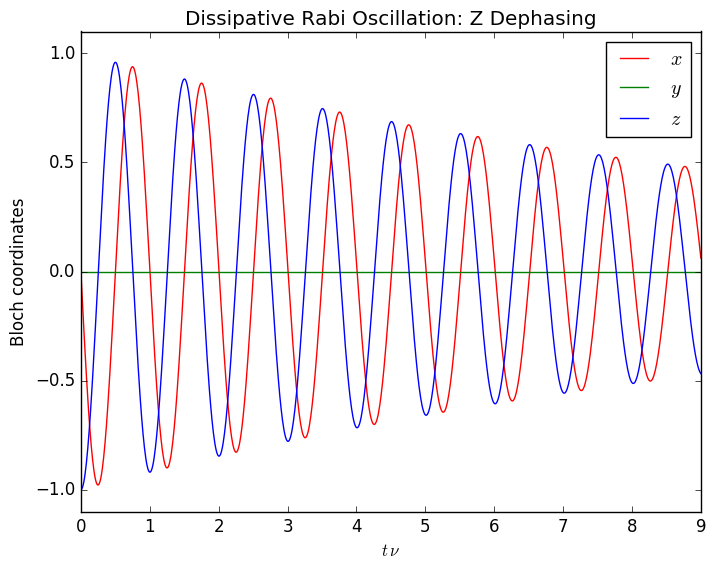

  0.042174 seconds (155.49 k allocations: 11.424 MB, 10.22% gc time)


In [6]:
sol = ensemble_average() # Run once to JIT-compile before timing
@time sol = ensemble_average()
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z Dephasing")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.042926701 s, Steps per second: 20942.676214508076
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.037104529 s, Steps per second: 24228.84818184864


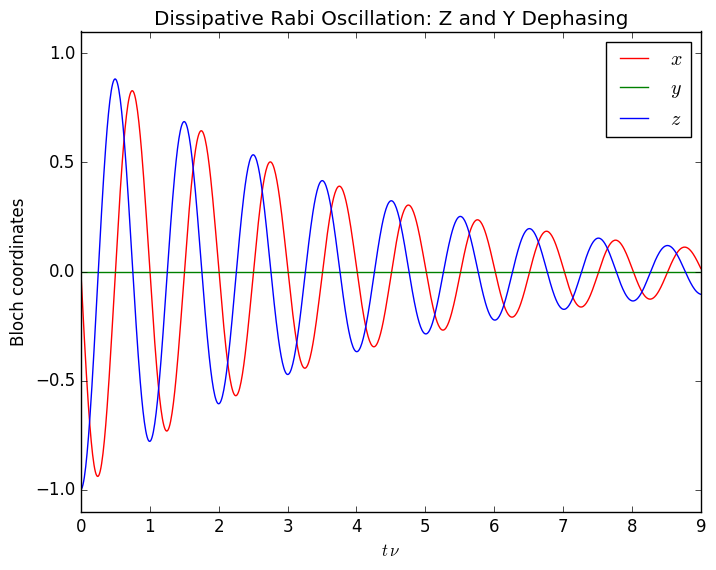

  0.038396 seconds (208.56 k allocations: 15.242 MB)


In [7]:
sol = ensemble_average(ymeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_average(ymeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z and Y Dephasing")

## Stochastic Dynamics Tests

Now we examine single trajectories and ensembles of trajectories carefully, to make sure they agree with the ensemble-averaged Lindblad dynamics.

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = -i[H,\,\rho]dt + \frac{\Gamma}{4}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{4}}\left[\sigma_z\,\rho + \rho\,\sigma_z^\dagger - \langle\sigma_z + \sigma_z^\dagger\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z\,e^{-i\phi} \equiv A_r - i\, A_i $$
whose real (Hermitian) part corresponds to the measured observable, and whose imaginary (anti-Hermitian) part corresponds to the phase back-action. 

This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -i\,\frac{dt\,A_i}{2\tau}\, -\, \frac{dt\,(r-A_r)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A_r^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A_r \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the Lindblad equation:
$$ \rho(t+dt) = \frac{\gamma\,dt}{4}\,\sigma_z\,\rho(t)\,\sigma_z^\dagger + \sqrt{1 - \frac{\gamma\,dt}{4}\sigma_z^\dagger\sigma_z}\,\rho(t)\,\sqrt{1 - \frac{\gamma\,dt}{4}\sigma_z^\dagger\sigma_z} $$

This complete unraveling into exact discrete-step Kraus operators has the enormous benefit of being a valid completely positive map that preserves the properties of the state. Other methods for integrating the stochastic master equation do not converge in precision easily, comparatively.

In [8]:
function ensemble_realization(; Δt=1/10^2, η=1.0, n=1, ymeas=false, ϕ=0.0)
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, [(exp(-im*ϕ).*q("z"), τ/η, η)])
    ymeas && (inc = meas(Δt, H, [(exp(-im*ϕ).*q("z"), τ/η, η), (exp(-im*ϕ).*q("y"), τ/η, η)]))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=true, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=true, readout=true)
    end
end;

### Single Trajectory Examples

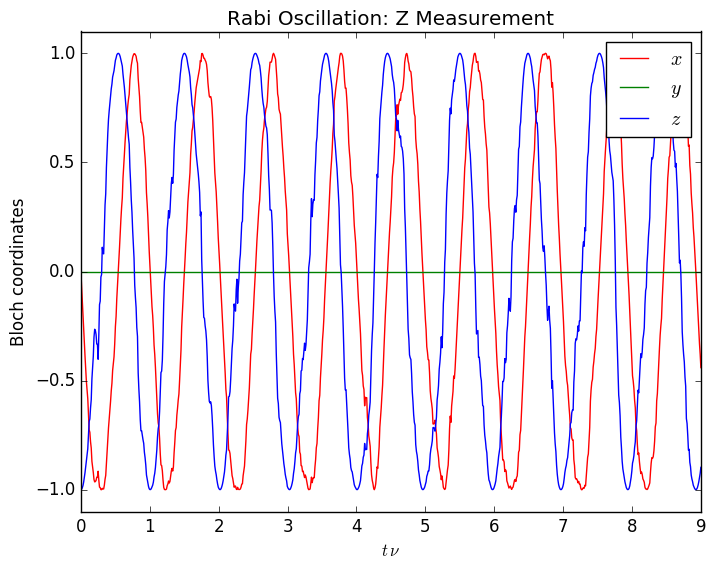

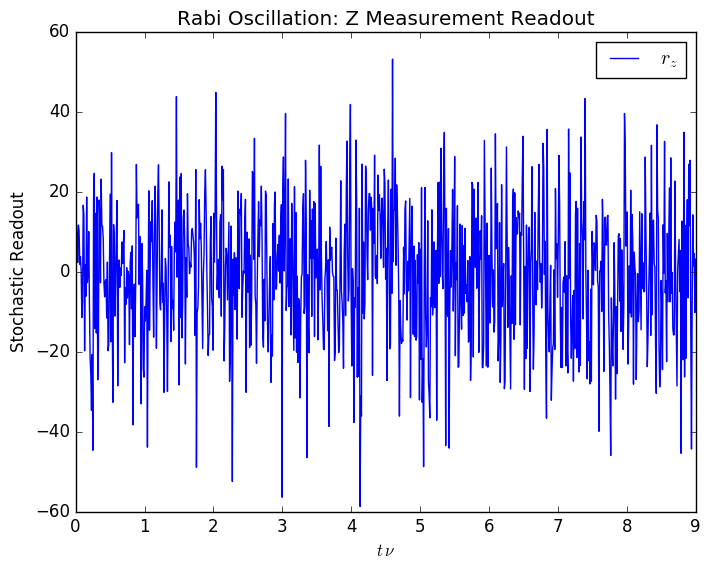

  0.031645 seconds (193.82 k allocations: 14.282 MB)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.056528988 s, Steps per second: 15903.345023618678
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.031165893 s, Steps per second: 28845.635836585847


In [9]:
sol = ensemble_realization() # Run once to JIT-compile before timing
@time sol = ensemble_realization()
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.060246701 s, Steps per second: 14921.978881466057
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.056978814 s, Steps per second: 15777.794181535613


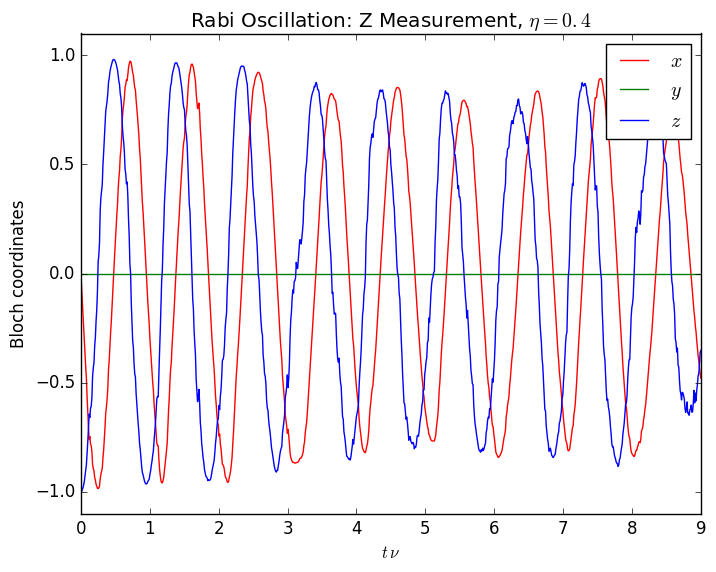

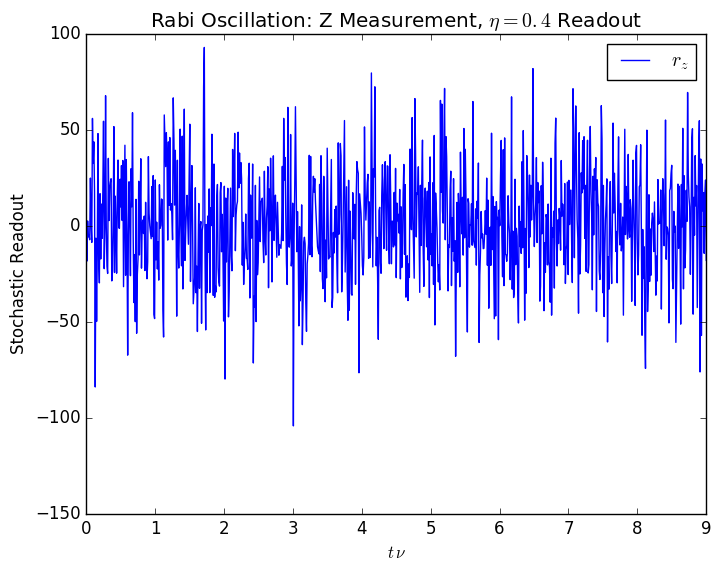

  0.057572 seconds (269.52 k allocations: 20.258 MB, 7.38% gc time)


In [10]:
sol = ensemble_realization(η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.048925378 s, Steps per second: 18374.921906581898
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.058133728 s, Steps per second: 15464.3445539911


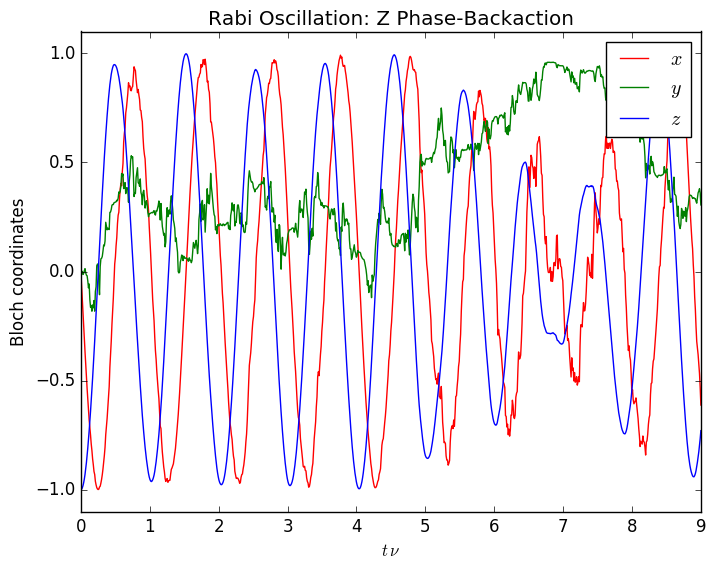

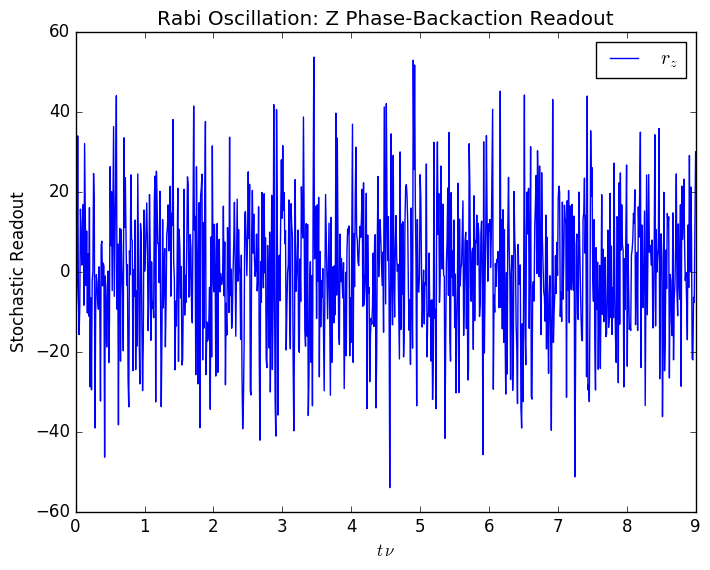

  0.058747 seconds (206.32 k allocations: 14.177 MB, 11.84% gc time)


In [11]:
sol = ensemble_realization(ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.075877468 s, Steps per second: 11848.049542190838
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.056140661 s, Steps per second: 16013.349041259062


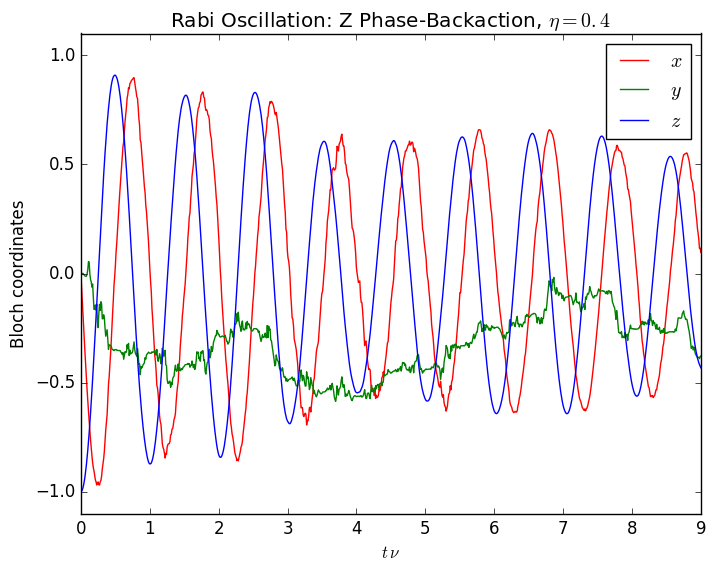

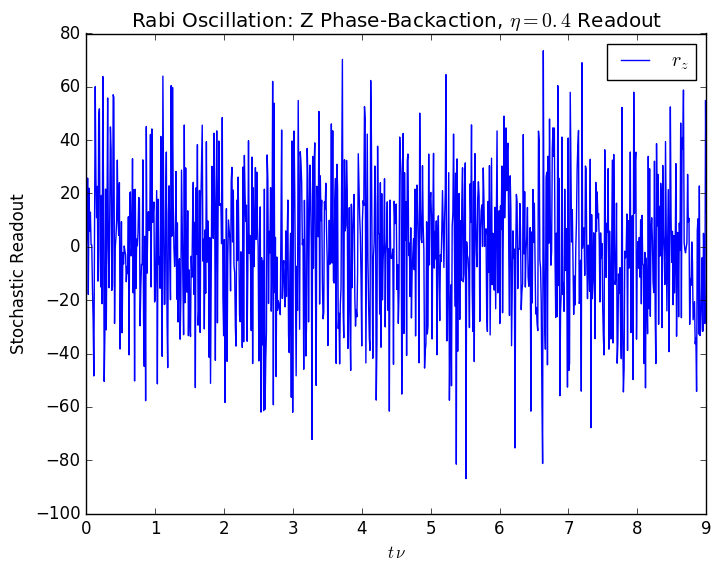

  0.056700 seconds (280.64 k allocations: 19.999 MB, 7.00% gc time)


In [12]:
sol = ensemble_realization(ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Phase-Backaction, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.183846812 s, Steps per second: 4889.940653417477
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.127108572 s, Steps per second: 7072.6937283191255


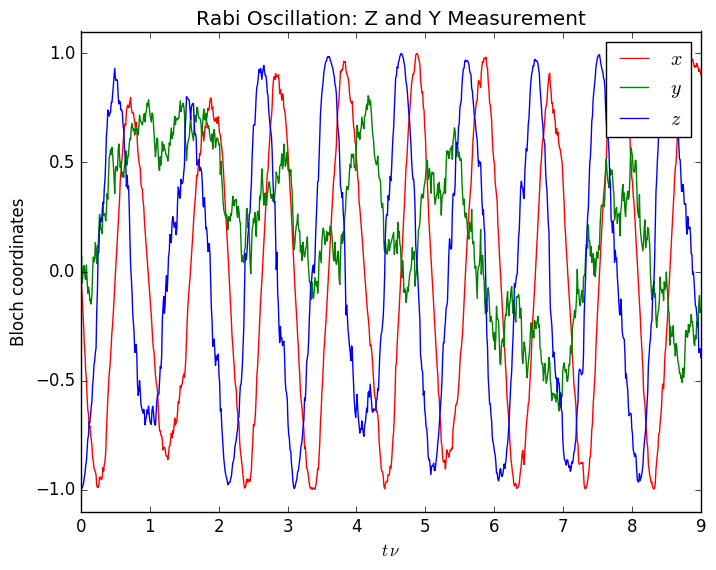

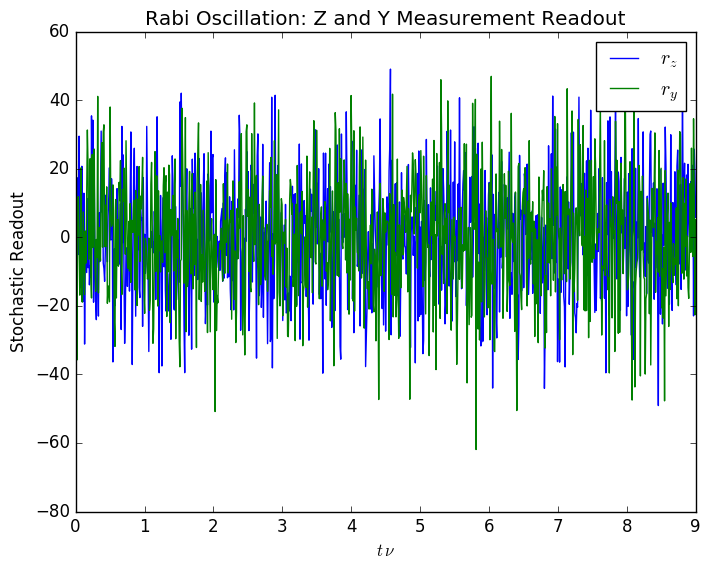

  0.128353 seconds (286.45 k allocations: 22.373 MB, 3.49% gc time)


In [13]:
sol = ensemble_realization(ymeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.087289191 s, Steps per second: 10299.09877386766
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.081660735 s, Steps per second: 11008.962875487221


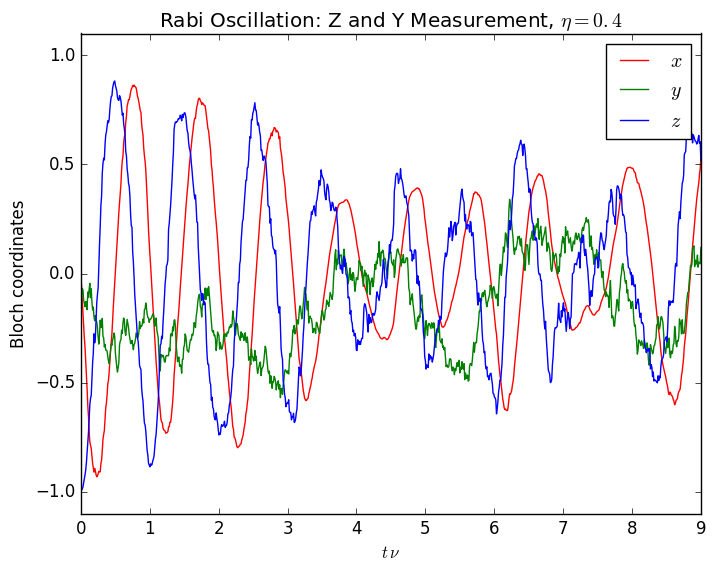

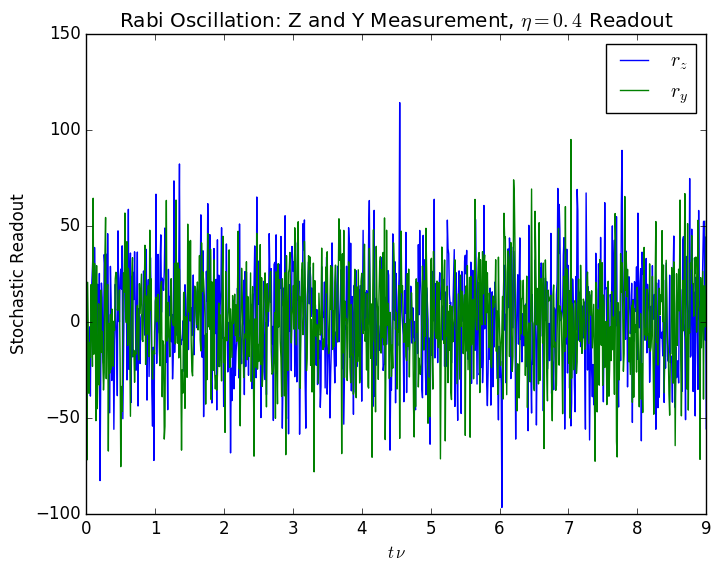

  0.082430 seconds (415.11 k allocations: 32.130 MB, 3.69% gc time)


In [14]:
sol = ensemble_realization(ymeas=true, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.082191778 s, Steps per second: 10937.833708865624
INFO: Trajectory: steps = 899, points = 899, values = 3


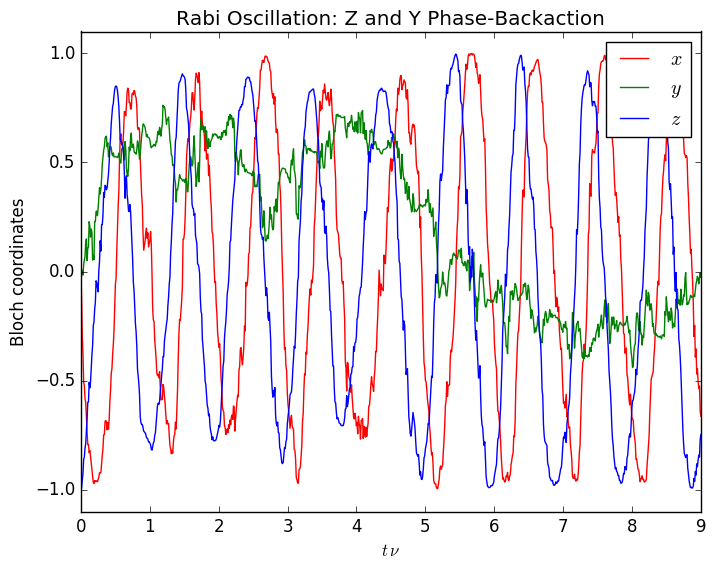

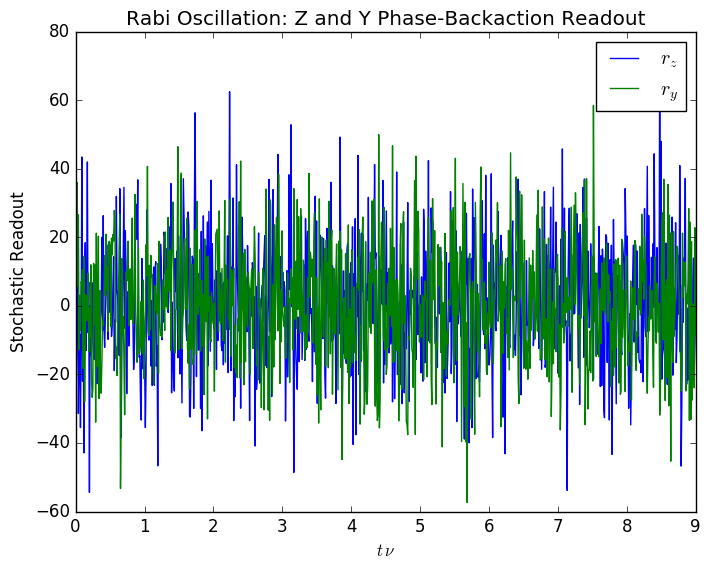

  0.047770 seconds (311.31 k allocations: 22.153 MB, 5.66% gc time)


INFO: Readout: values = 2
INFO: Time elapsed: 0.047085097 s, Steps per second: 19093.090112992653


In [15]:
sol = ensemble_realization(ymeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.08571464 s, Steps per second: 10488.289981734742
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.079231172 s, Steps per second: 11346.544261644898


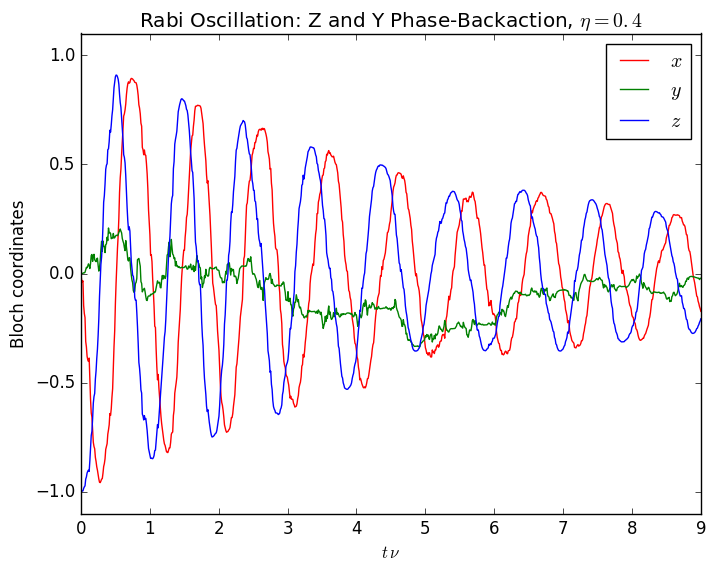

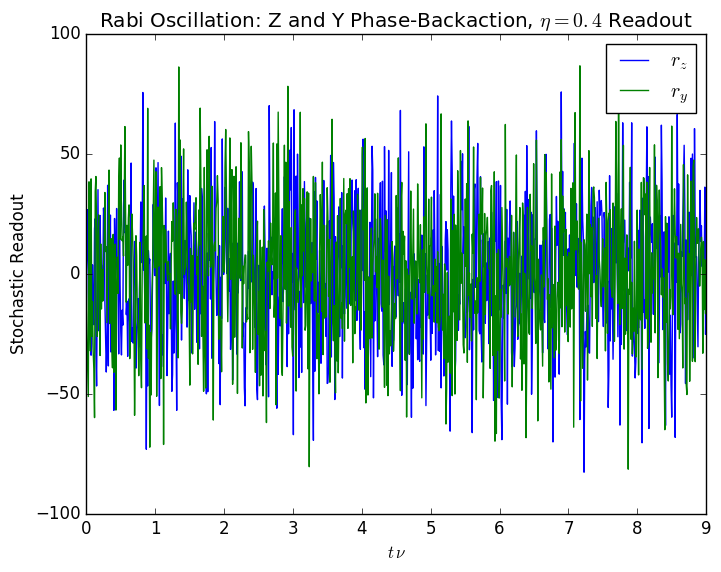

  0.079921 seconds (437.31 k allocations: 31.641 MB, 3.15% gc time)


In [16]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Phase-Backaction, $\eta=0.4$")

### Ensembles of trajectories

In [17]:
# Ensemble size, for easy tunability
num = 2000;

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 3.809039801 s, Steps: 1798, Steps per second: 472.0349730995105
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


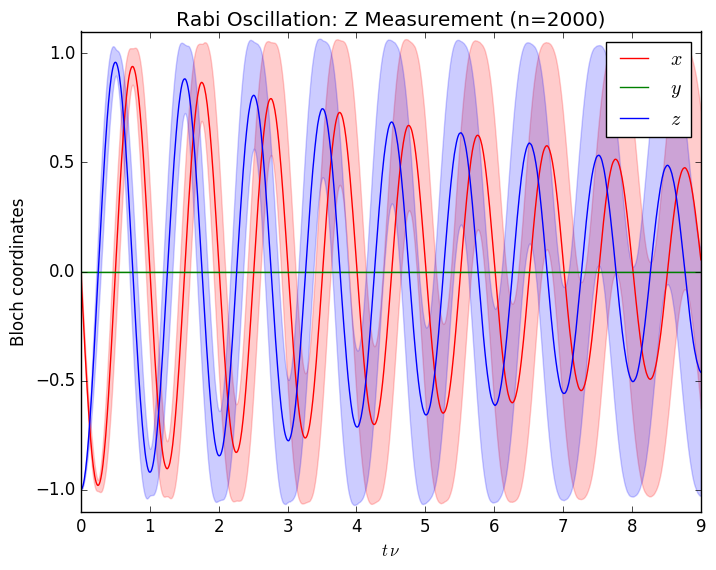

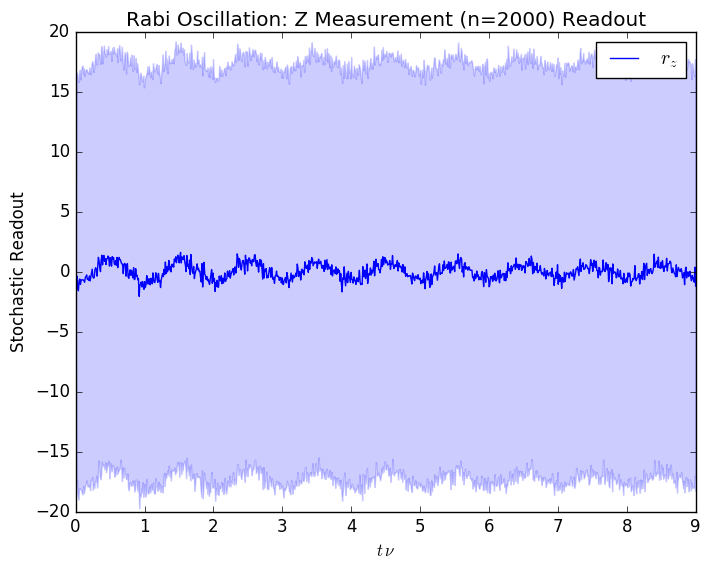

 35.335423 seconds (1.71 M allocations: 156.859 MB, 0.42% gc time)


INFO: Time elapsed: 35.20318133 s, Steps: 1798000, Steps per second: 51074.929369174715


In [18]:
e = ensemble_realization(n=2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.414298544 s, Steps: 1798, Steps per second: 4339.865601844838
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


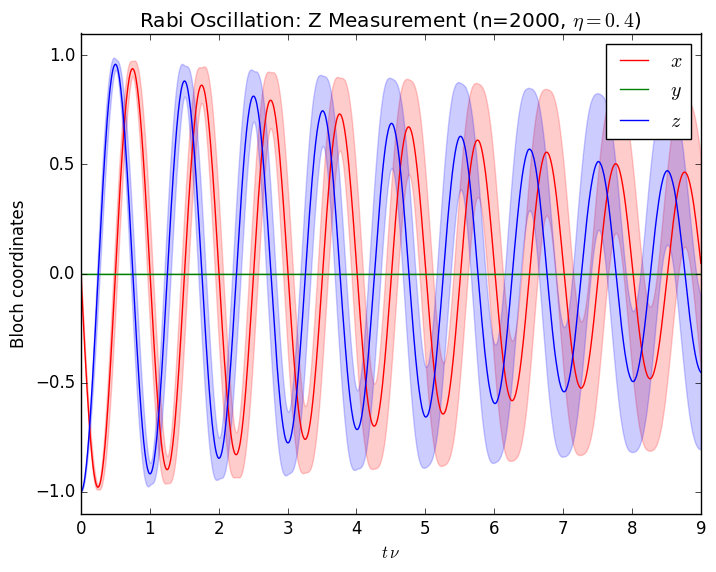

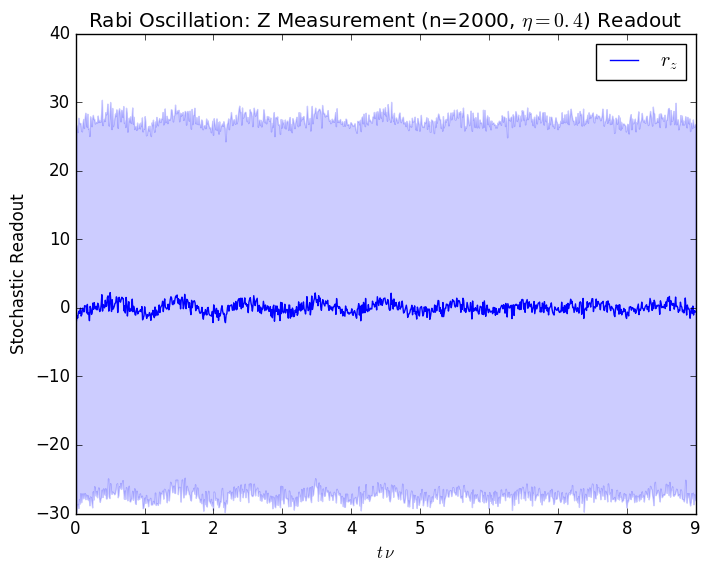

 60.300577 seconds (1.86 M allocations: 154.167 MB, 0.19% gc time)


INFO: Time elapsed: 60.187597111 s, Steps: 1798000, Steps per second: 29873.264365149313


In [19]:
e = ensemble_realization(n=2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Measurement (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.10411638 s, Steps: 1798, Steps per second: 17269.136710285165
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


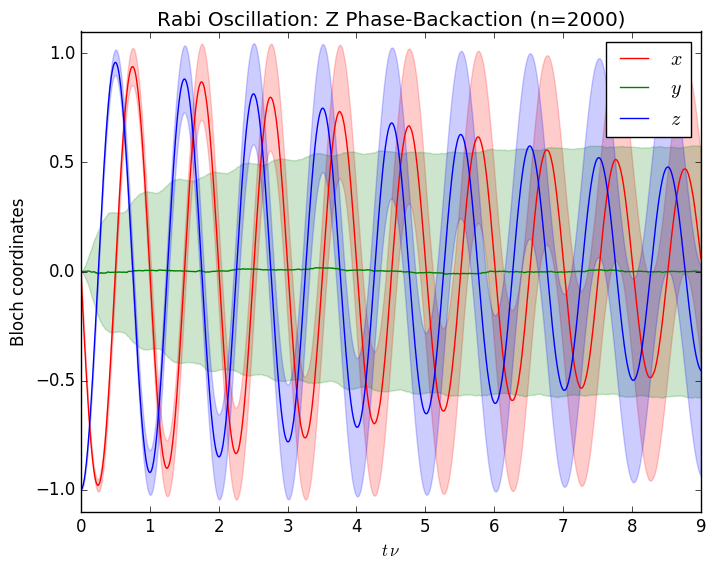

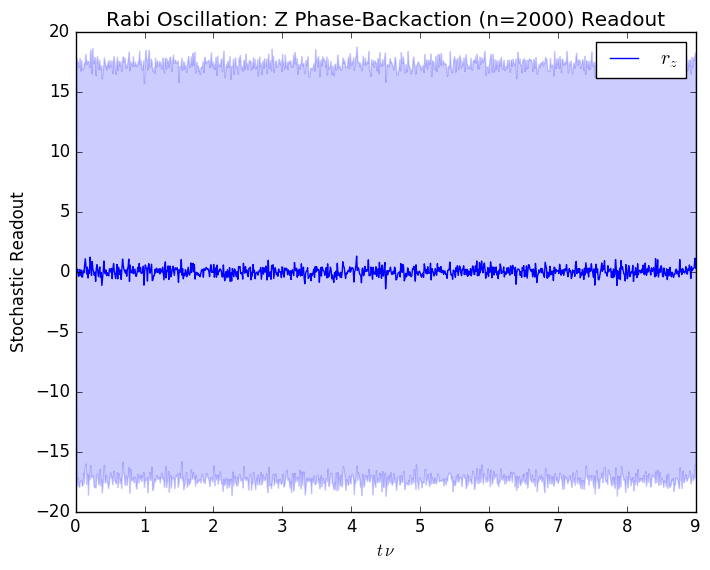

 34.983915 seconds (1.51 M allocations: 147.634 MB, 0.10% gc time)


INFO: Time elapsed: 34.935182871 s, Steps: 1798000, Steps per second: 51466.740753560945


In [20]:
e = ensemble_realization(n=2, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.057956178 s, Steps: 1798, Steps per second: 31023.439813439734
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


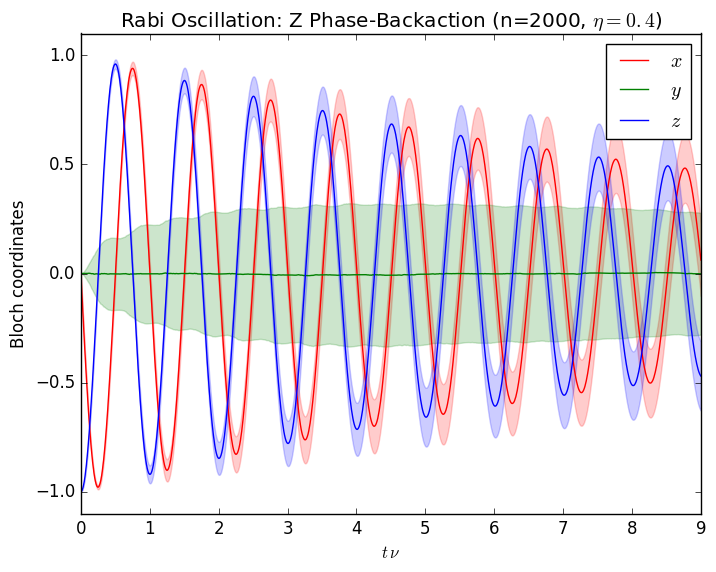

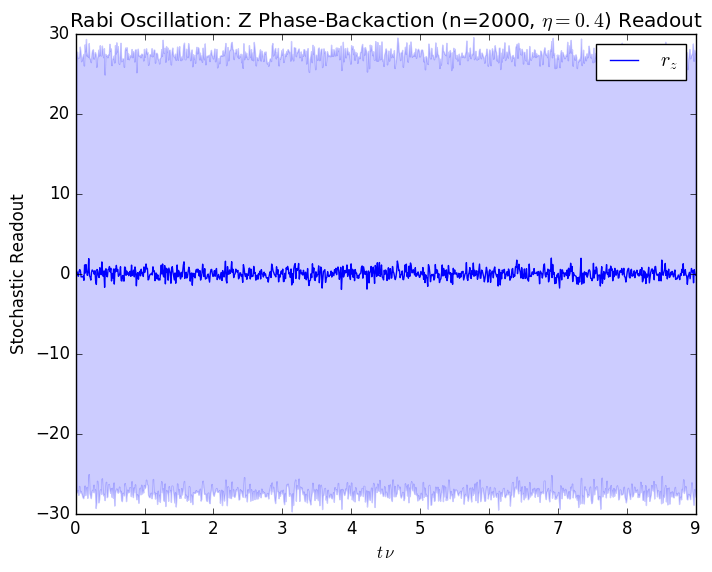

 63.050597 seconds (1.86 M allocations: 154.175 MB, 0.20% gc time)


INFO: Time elapsed: 63.011035478 s, Steps: 1798000, Steps per second: 28534.684224127108


In [21]:
e = ensemble_realization(n=2, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Phase-Backaction (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.175783395 s, Steps: 1798, Steps per second: 10228.49740727786
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


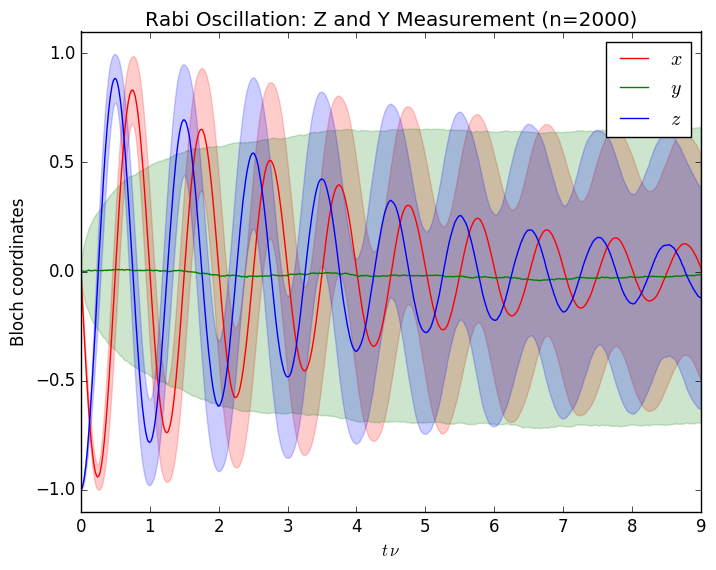

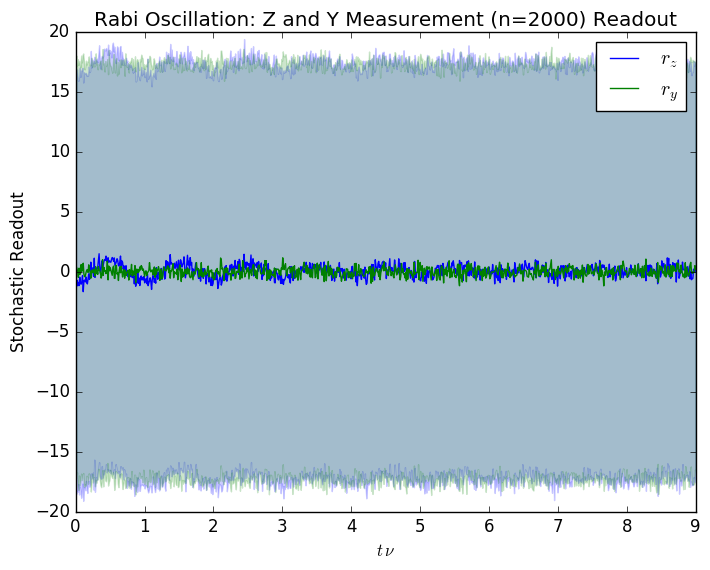

 49.473848 seconds (1.88 M allocations: 182.900 MB, 0.21% gc time)


INFO: Time elapsed: 49.345879942 s, Steps: 1798000, Steps per second: 36436.67925495152


In [22]:
e = ensemble_realization(n=2, ymeas=true) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.188699544 s, Steps: 1798, Steps per second: 9528.374906936711
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


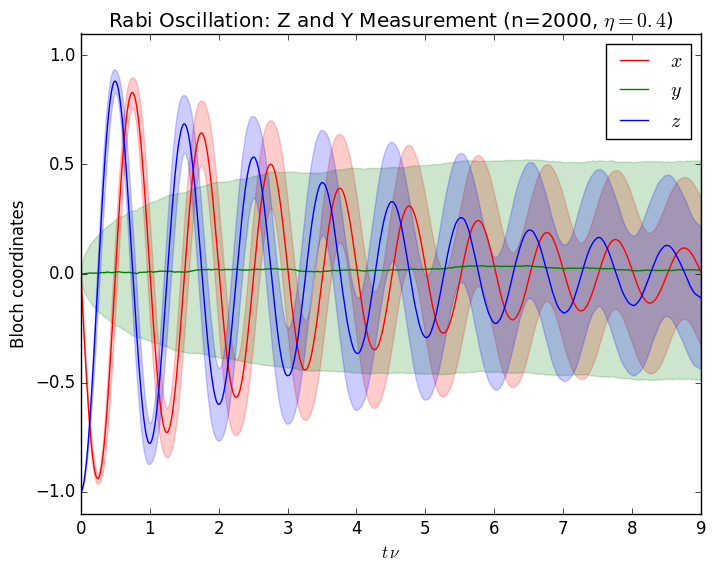

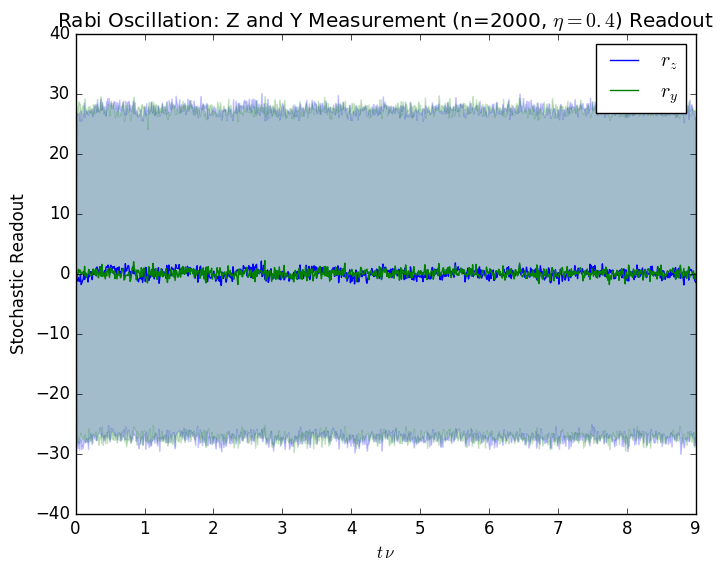

 86.197834 seconds (2.37 M allocations: 191.930 MB, 0.13% gc time)


INFO: Time elapsed: 86.065250033 s, Steps: 1798000, Steps per second: 20891.126201464504


In [23]:
e = ensemble_realization(n=2, ymeas=true, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.089868315 s, Steps: 1798, Steps per second: 20007.051428526283
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


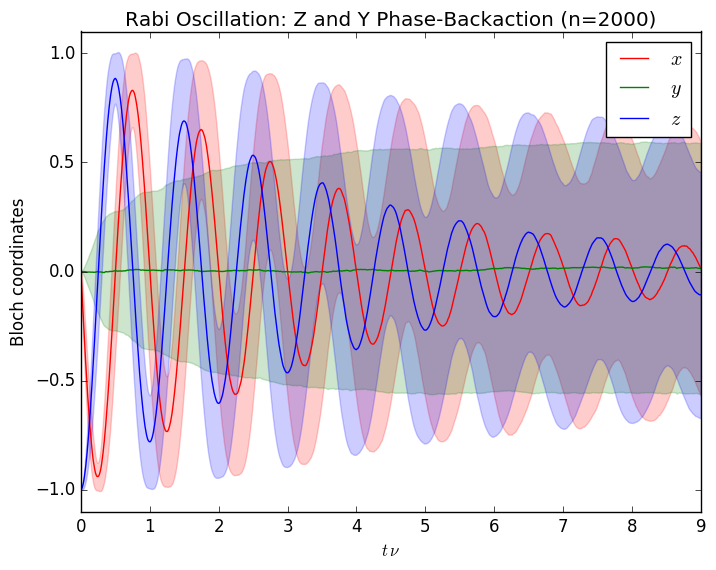

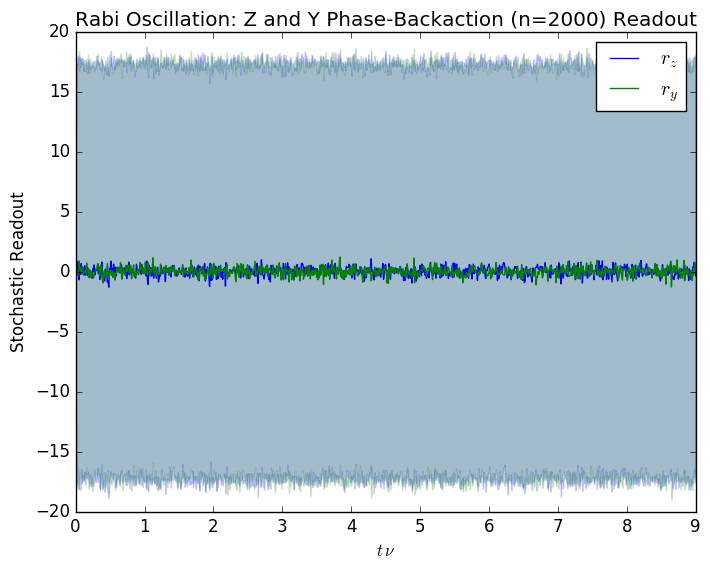

 49.320099 seconds (1.88 M allocations: 182.901 MB, 0.21% gc time)


INFO: Time elapsed: 49.190508718 s, Steps: 1798000, Steps per second: 36551.76673019583


In [24]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.153712754 s, Steps: 1798, Steps per second: 11697.142580634525
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


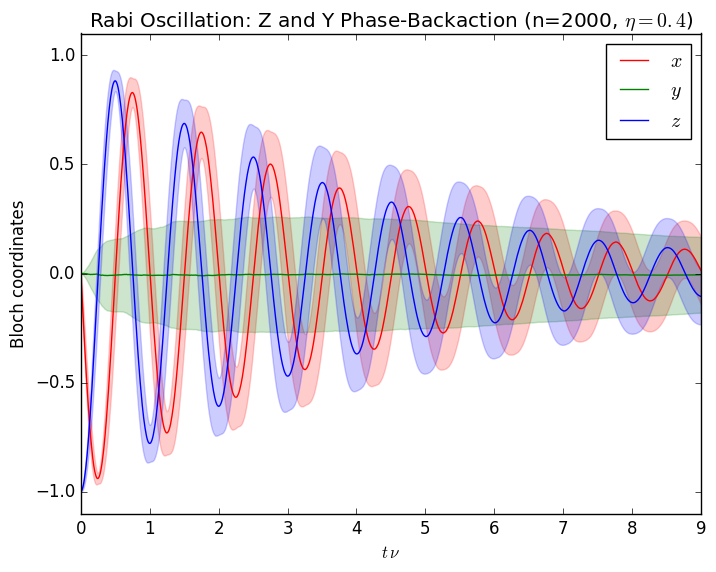

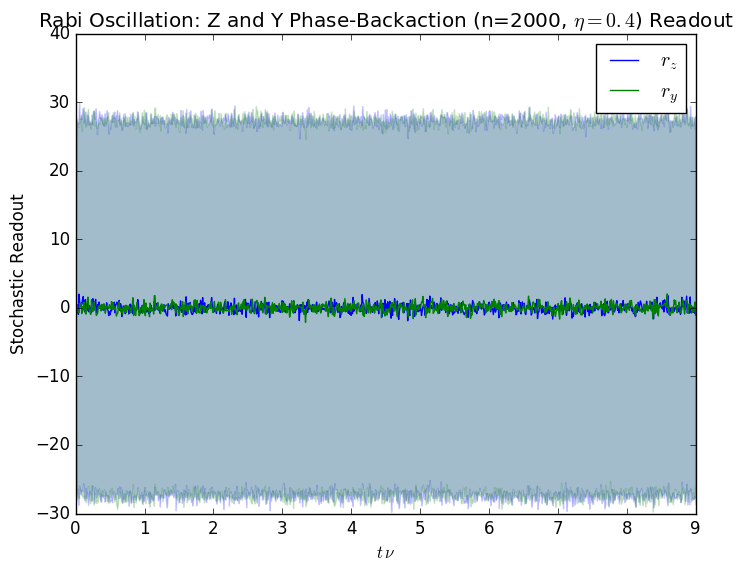

 88.453956 seconds (2.37 M allocations: 191.919 MB, 0.13% gc time)


INFO: Time elapsed: 88.325541362 s, Steps: 1798000, Steps per second: 20356.512649392575


In [25]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

## Conclusions

The Quantum Bayesian method for computing stochastic evolution works well and is competitive in speed with the direct Lindblad integration. It is both dramatically faster and much more accurate than any of the available stochastic integration solvers in the ```DifferentialEquations``` package.

## Version Information

In [26]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [27]:
Pkg.installed("PyPlot")

v"2.2.4"

In [28]:
Pkg.installed("QuantumBayesian")

v"0.0.0-"